In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from config import TurbVaeConfig as cfg

from train2d import VAETrainer
torch.set_grad_enabled(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# model = VAETrainer.load_from_checkpoint("/home/dane2/Code/turb_vae/checkpoints/epoch=0-step=15620-v2.ckpt", cfg = cfg).to(device)
model = VAETrainer.load_from_checkpoint("/home/dane2/Code/turb_vae/checkpoints/epoch=0-step=15625.ckpt", cfg = cfg).to(device)
encoder = model.vae.encoder
data = cfg.test_dataset
N1 = 300
dl = torch.utils.data.DataLoader(data, batch_size=N1, num_workers=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [2]:
batch = next(iter(dl))

In [3]:
N2 = 100
n, L0 = batch
_, dist = model.vae(n.to(device))

z = dist.rsample((N2,))
z.shape

torch.Size([100, 300, 1024])

In [4]:
# combine all the samples
z = z.view(-1, z.shape[-1])
z.shape

torch.Size([30000, 1024])

In [5]:
# mean stats
mu_est = z.mean(axis=0, keepdim=True)
mu_est.mean(), mu_est.std() / np.sqrt(N1*N2)

(tensor(-0.0058), tensor(0.0002))

In [6]:
mu_est.shape

torch.Size([1, 1024])

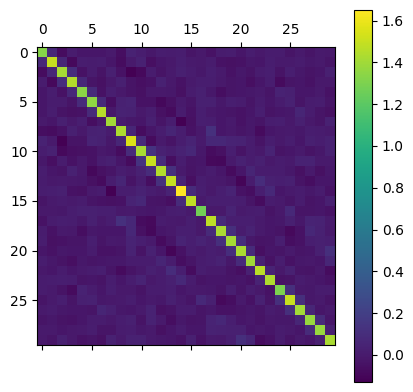

In [7]:
# covariance stats
cov_est = torch.cov(z.T)
cov_plt = cov_est[:30, :30].numpy()

plt.matshow(cov_plt)
plt.colorbar()


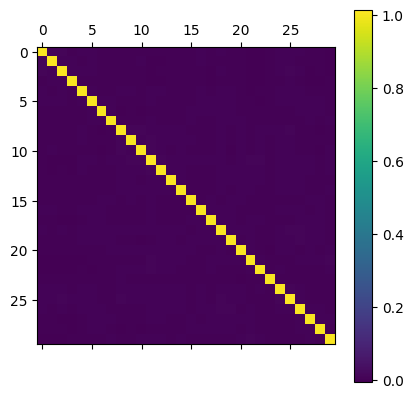

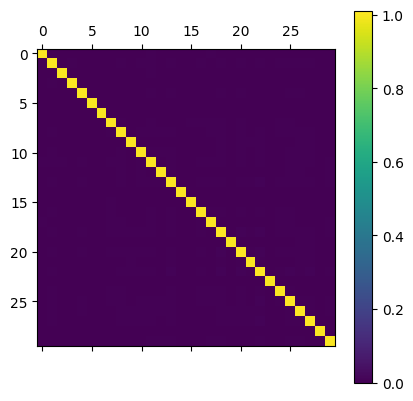

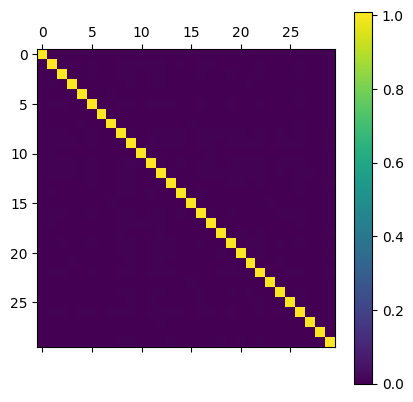

In [10]:
for i in range(3):
    plt.matshow(dist.covariance_matrix[i, :30, :30].cpu().numpy())
    plt.colorbar()
    plt.show()

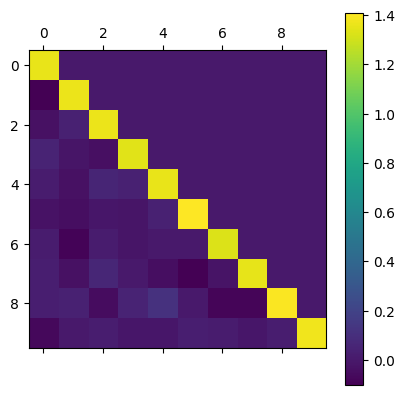

In [9]:
plt.matshow(dist._capacitance_tril[0])
plt.colorbar()